In [1]:
# General Imports
import os
import numpy as np
import pandas as pd
from time import strftime, localtime
import matplotlib.pyplot as plt
from skimage.transform import resize

import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, cohen_kappa_score, hamming_loss

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import check_random_state
import seaborn as sn 
sn.set(font_scale=3)  # for label size

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [10]:
LABELS_LIST = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
       'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
       'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
       'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
       'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
       'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
       'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
       'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
       'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
       'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
       'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
       'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
       'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
       'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [4]:
def create_optimized_results_report(experiment_path,VALIDATION_SIZE = 1000):
    model_output= np.loadtxt(os.path.join(experiment_path , "predictions.out"),delimiter=',')
    model_output_rounded = np.round(model_output)
    groundtruth = np.loadtxt(os.path.join(experiment_path , "test_ground_truth_classes.txt"),delimiter=',')
    results_df = pd.read_csv(os.path.join(experiment_path , "results_report.csv"),index_col = 0)
    results_df.drop('average',axis = 0, inplace = True)
    results_df = results_df.T

    validation_output = model_output[:VALIDATION_SIZE]
    validation_groundtruth = groundtruth[:VALIDATION_SIZE]

    model_output = model_output[VALIDATION_SIZE:]
    groundtruth = groundtruth[VALIDATION_SIZE:]

    thresholds = np.arange(0, 1, 0.01)
    f1_array = np.zeros((len(LABELS_LIST), len(thresholds)))
    for idx, label in enumerate(LABELS_LIST):
        f1_array[idx, :] = [
            f1_score(validation_groundtruth[:, idx], np.clip(np.round(validation_output[:, idx] - threshold + 0.5), 0, 1))
            for threshold in thresholds]
    threshold_arg = np.argmax(f1_array, axis=1)
    threshold_per_class = thresholds[threshold_arg]

    # plot the f1 score across thresholds
    plt.figure(figsize=(20, 20))
    for idx, x in enumerate(LABELS_LIST):
        plt.plot(thresholds, f1_array[idx, :], linewidth=5)
    plt.legend(LABELS_LIST, loc='best')
    plt.title("F1 Score vs different prediction threshold values for each class")
    #plt.savefig(os.path.join(output_path, "f1_score_vs_thresholds.pdf"), format="pdf")
    #plt.savefig(os.path.join(output_path, "f1_score_vs_thresholds.png"))

    # Applying thresholds optimized per class
    model_output_rounded = np.zeros_like(model_output)
    for idx, label in enumerate(LABELS_LIST):
        model_output_rounded[:, idx] = np.clip(np.round(model_output[:, idx] - threshold_per_class[idx] + 0.5), 0, 1)

    accuracies_perclass = sum(model_output_rounded == groundtruth) / len(groundtruth)
    # Getting the true positive rate perclass
    true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(
        groundtruth)
    # Get true negative ratio
    true_negative_ratio_perclass = sum((model_output_rounded == groundtruth)
                                       * (groundtruth == 0)) / (len(groundtruth) - sum(groundtruth))
    results_df = results_df.append(
        pd.DataFrame([accuracies_perclass, true_positives_ratio_perclass,
                      true_negative_ratio_perclass], columns=LABELS_LIST))
    # compute additional metrics (AUC,f1,recall,precision)
    auc_roc_per_label = roc_auc_score(groundtruth, model_output, average=None)
    precision_perlabel = precision_score(groundtruth, model_output_rounded, average=None)
    recall_perlabel = recall_score(groundtruth, model_output_rounded, average=None)
    f1_perlabel = f1_score(groundtruth, model_output_rounded, average=None)
    kappa_perlabel = [cohen_kappa_score(groundtruth[:, x], model_output_rounded[:, x]) for x in
                      range(len(LABELS_LIST))]
    results_df = results_df.append(
        pd.DataFrame([auc_roc_per_label, recall_perlabel, precision_perlabel, f1_perlabel,kappa_perlabel],
                     columns=LABELS_LIST))
    results_df.index = ['Ratio of positive samples', 'Model accuracy', 'True positives ratio',
                        'True negatives ratio', "AUC", "Precision", "Recall", "f1-score",  "Kappa score",
                        'Optimized model accuracy', 'Optimized true positives ratio',
                        'Optimized true negatives ratio', "Optimized AUC",
                        "Optimized recall", "Optimized precision", "Optimized f1-score",  "Optimized Kappa score"]

    # Creating evaluation plots
    plot_true_poisitve_vs_all_positives(model_output_rounded, groundtruth,
                                        os.path.join(experiment_path, 'TruePositive_vs_allPositives[optimized]'),
                                        LABELS_LIST)
    #plot_output_coocurances(model_output_rounded, os.path.join(experiment_path, 'output_coocurances[optimized]'),
    #                        LABELS_LIST)
    #plot_false_netgatives_confusion_matrix(model_output_rounded, groundtruth,
    #                                       os.path.join(experiment_path, 'false_negative_coocurances[optimized]'),
    #                                       LABELS_LIST)
    results_df['average'] = results_df.mean(numeric_only=True, axis=1)
    results_df.T.to_csv(os.path.join(experiment_path, "results_report_optimized.csv"), float_format="%.2f")
    return results_df.T

## Computing and plotting results

In [2]:
# results for the orginal cross entropy (CE)
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results_balanced/"
MICRO_OCE_results_pd = pd.DataFrame()
for split in np.arange(1,5):
    for ratio in np.arange(0,1,0.25): 
        experiment_path = OUTPUT_PATH+'PosLimited_original_CE_balanced_ratio'  + str(round(ratio, 1)) + 'split_' + str(split)
        dirs = os.listdir(experiment_path)
        predictions = np.loadtxt(experiment_path + '/' + dirs[0] + '/predictions.out',delimiter=',')
        groundtruth = np.loadtxt(experiment_path + '/' + dirs[0] + '/test_ground_truth_classes.txt',delimiter=',')
        pred_rounded = np.round(predictions)
        recall = recall_score(groundtruth, pred_rounded, average='micro')
        precision = precision_score(groundtruth, pred_rounded, average='micro')
        f1 = f1_score(groundtruth, pred_rounded, average='micro')
        auc = roc_auc_score(groundtruth, predictions, average='micro')
        split_ratio_results = pd.DataFrame({"Recall": [recall], "Precision": [precision], "f1-score": [f1], 'AUC' : [auc]})
        split_ratio_results['ratio'] = ratio
        MICRO_OCE_results_pd = pd.concat([MICRO_OCE_results_pd,split_ratio_results])

In [3]:
# results for the ignore missing weighted cross entropy (IM-WCE)
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results_balanced/"
MICRO_weighted_CE_results_pd = pd.DataFrame()
for split in np.arange(1,5):
    for ratio in np.arange(0,1,0.25): 
        experiment_path = OUTPUT_PATH+'PosLimitited_weighted_CE_balanced_ratio'  + str(round(ratio, 1)) + 'split_' + str(split)
        dirs = os.listdir(experiment_path)
        predictions = np.loadtxt(experiment_path + '/' + dirs[0] + '/predictions.out',delimiter=',')
        groundtruth = np.loadtxt(experiment_path + '/' + dirs[0] + '/test_ground_truth_classes.txt',delimiter=',')
        pred_rounded = np.round(predictions)
        recall = recall_score(groundtruth, pred_rounded, average='micro')
        precision = precision_score(groundtruth, pred_rounded, average='micro')
        f1 = f1_score(groundtruth, pred_rounded, average='micro')
        auc = roc_auc_score(groundtruth, predictions, average='micro')
        split_ratio_results = pd.DataFrame({"Recall": [recall], "Precision": [precision], "f1-score": [f1], 'AUC' : [auc]})
        split_ratio_results['ratio'] = ratio
        #split_ratio_results['split'] = split 
        MICRO_weighted_CE_results_pd = pd.concat([MICRO_weighted_CE_results_pd,split_ratio_results])

In [4]:
# results for the correlation-based weighted cross entropy (CB-WCE)
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results_balanced/"
MICRO_correlation_CE_results_pd = pd.DataFrame()
for split in np.arange(1,5):
    for ratio in np.arange(0,1,0.25): 
        experiment_path = OUTPUT_PATH+'CORRELATION_weighted_CE_balanced_ratio'  + str(round(ratio, 1)) + 'split_' + str(split)
        dirs = os.listdir(experiment_path)
        predictions = np.loadtxt(experiment_path + '/' + dirs[0] + '/predictions.out',delimiter=',')
        groundtruth = np.loadtxt(experiment_path + '/' + dirs[0] + '/test_ground_truth_classes.txt',delimiter=',')
        pred_rounded = np.round(predictions)
        recall = recall_score(groundtruth, pred_rounded, average='micro')
        precision = precision_score(groundtruth, pred_rounded, average='micro')
        f1 = f1_score(groundtruth, pred_rounded, average='micro')
        auc = roc_auc_score(groundtruth, predictions, average='micro')
        split_ratio_results = pd.DataFrame({"Recall": [recall], "Precision": [precision], "f1-score": [f1], 'AUC' : [auc]})
        split_ratio_results['ratio'] = ratio
        #split_ratio_results['split'] = split 
        MICRO_correlation_CE_results_pd = pd.concat([MICRO_correlation_CE_results_pd,split_ratio_results])

In [5]:
MICRO_OCE_results_pd['method'] = 'CE'
MICRO_weighted_CE_results_pd['method']= 'IM-WCE'
MICRO_correlation_CE_results_pd['method'] = 'CB-WCE'
all_results = pd.concat([MICRO_OCE_results_pd,MICRO_weighted_CE_results_pd,MICRO_correlation_CE_results_pd])

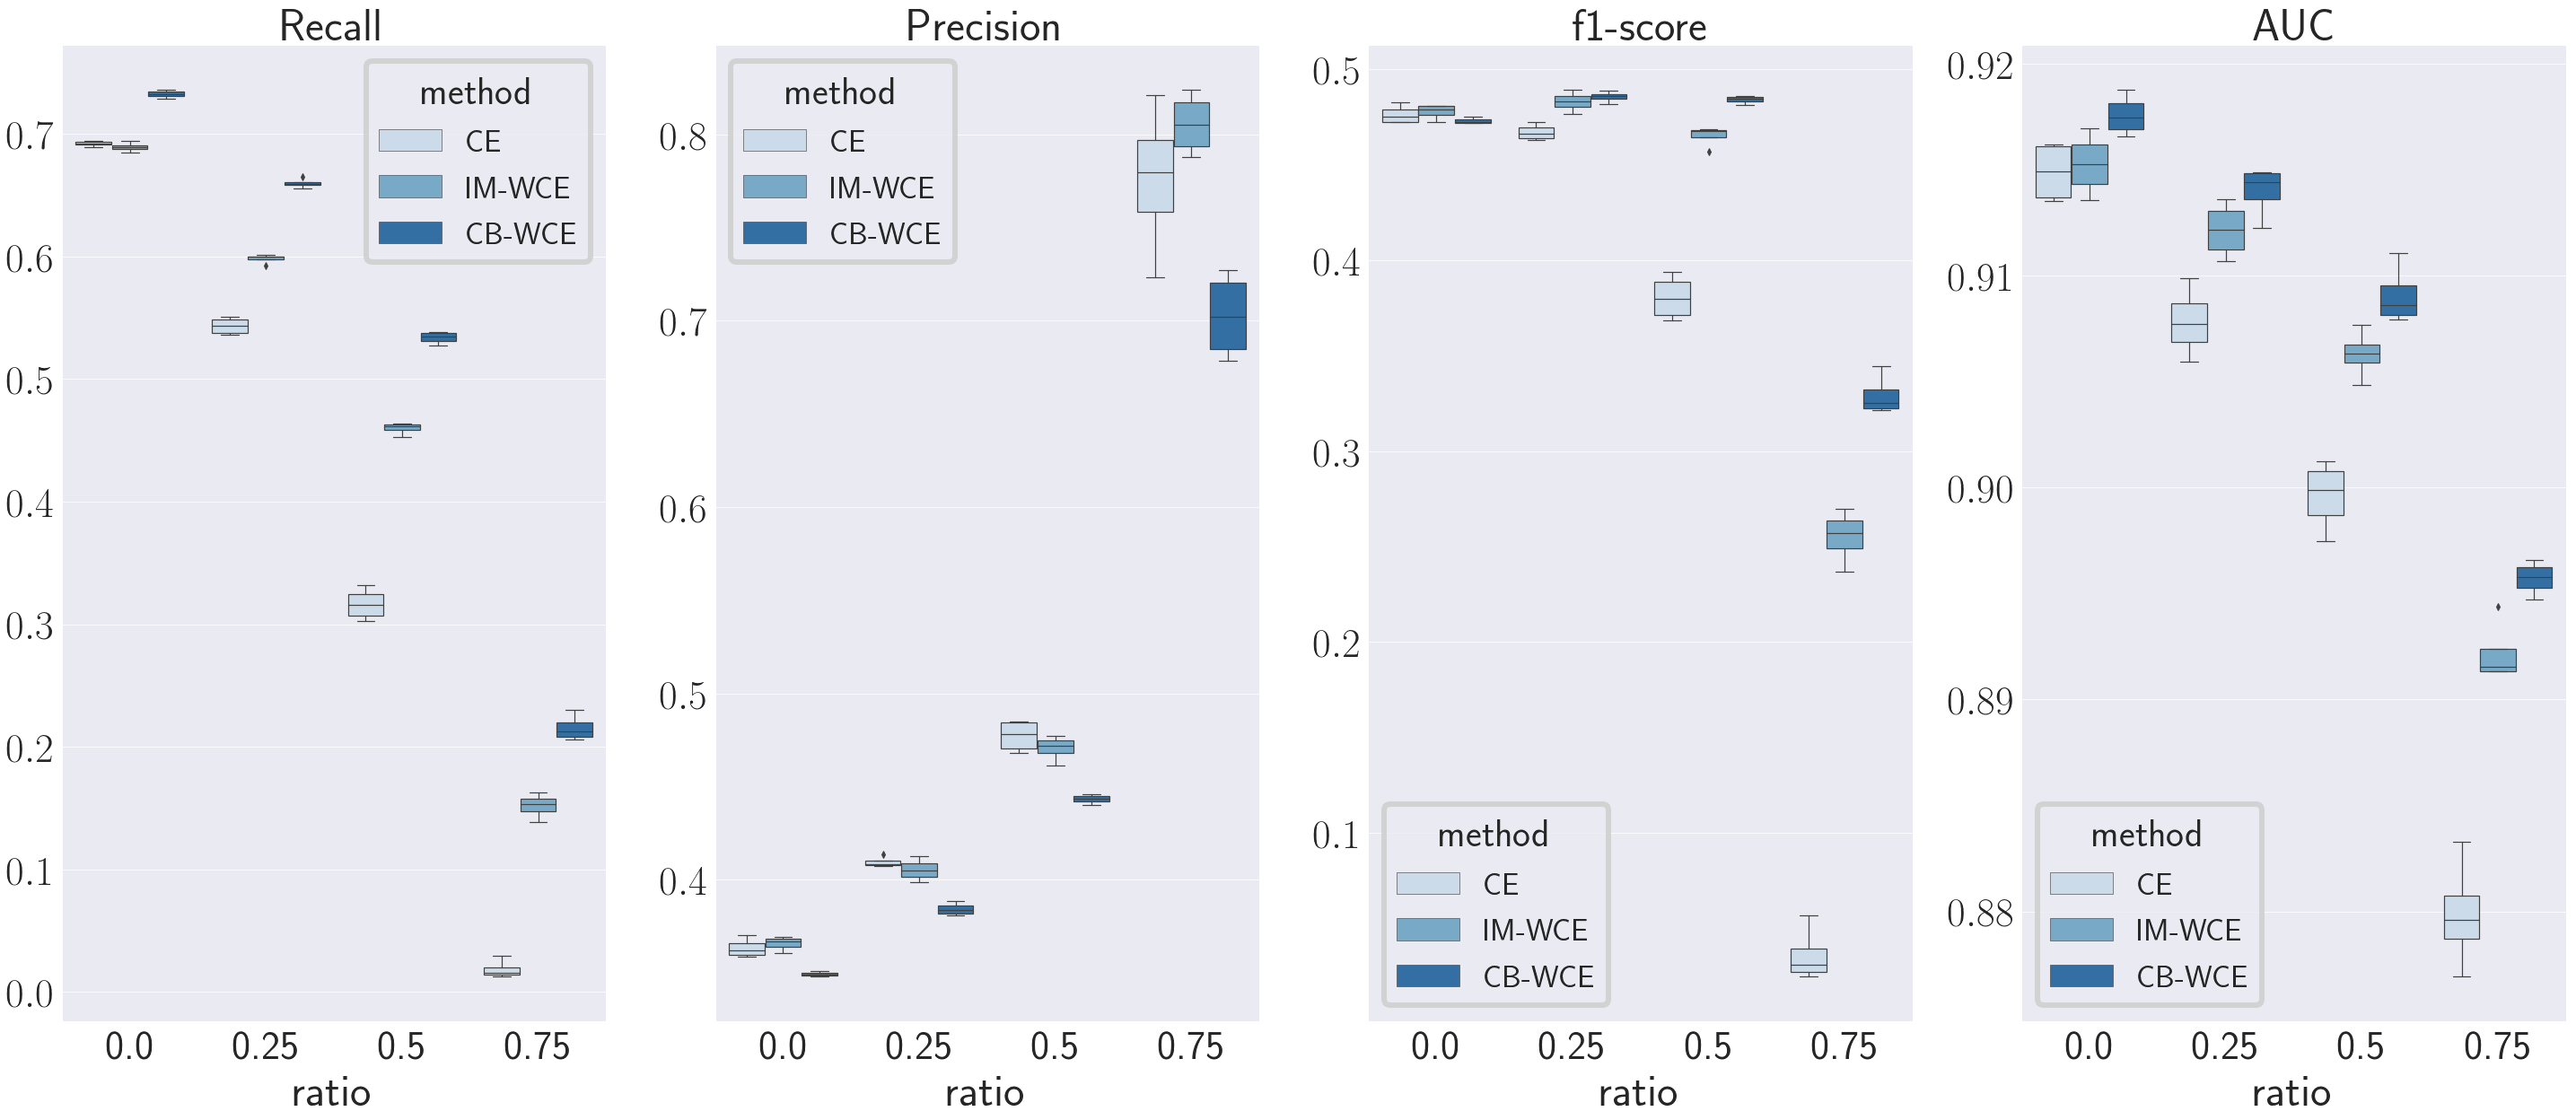

In [7]:
# Plot the results
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

sn.set_context("paper", rc={"font.size":50,"axes.titlesize":50,
    "axes.labelsize" : 50,
    "xtick.labelsize" : 45,
    "ytick.labelsize" : 45,
    "legend.fontsize":35 })  
plt.rcParams['patch.linewidth'] = 6
plt.rcParams['patch.edgecolor'] = (1,0,0,0)
plt.rcParams["patch.force_edgecolor"] = False

#sn.set(font_scale=3)  # for label size
fig, ax_new = plt.subplots(1,4, sharey=False,figsize = [50,20])
columns_To_plot = all_results.columns[:-2]
for column, plot_column in zip(columns_To_plot,ax_new.flatten()):
    ax = sn.boxplot(y=column, x='ratio', 
                     data=all_results,
                     palette=sn.color_palette("Blues", 3),
                     hue='method',ax =plot_column)
    plot_column.title.set_text(column)
    plot_column.set_ylabel('')


#fig.set_xlabel("X Label",fontsize=30)
#fig.set_ylabel("Y Label",fontsize=20)
#fig.suptitle("Classification metrics across different ratios of missing labels on the MSCOCO dataset", fontsize=60)                           
plt.savefig('/srv/workspace/research/mlml/figures/mscocoresults.pdf',dpi=300, format = 'pdf',bbox_inches='tight')


## Plotting ratios of positive predictions

In [13]:
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results_balanced/"
MICRO_OCE_results_pd = pd.DataFrame()
#for split in np.arange(1,5):
#    for ratio in np.arange(0,1,0.25): 
split = 1
ratio = 0.5
experiment_path = OUTPUT_PATH+'PosLimited_original_CE_balanced_ratio'  + str(round(ratio, 1)) + 'split_' + str(split)
dirs = os.listdir(experiment_path)
predictions = np.loadtxt(experiment_path + '/' + dirs[0] + '/predictions.out',delimiter=',')
groundtruth = np.loadtxt(experiment_path + '/' + dirs[0] + '/test_ground_truth_classes.txt',delimiter=',')
pred_rounded_original = np.round(predictions)



experiment_path = OUTPUT_PATH+'PosLimitited_weighted_CE_balanced_ratio'  + str(round(ratio, 1)) + 'split_' + str(split)
dirs = os.listdir(experiment_path)
predictions = np.loadtxt(experiment_path + '/' + dirs[0] + '/predictions.out',delimiter=',')
groundtruth = np.loadtxt(experiment_path + '/' + dirs[0] + '/test_ground_truth_classes.txt',delimiter=',')
pred_rounded_weighted = np.round(predictions)


experiment_path = OUTPUT_PATH+'CORRELATION_weighted_CE_balanced_ratio'  + str(round(ratio, 1)) + 'split_' + str(split)
dirs = os.listdir(experiment_path)
predictions = np.loadtxt(experiment_path + '/' + dirs[0] + '/predictions.out',delimiter=',')
groundtruth = np.loadtxt(experiment_path + '/' + dirs[0] + '/test_ground_truth_classes.txt',delimiter=',')
pred_rounded_correlation = np.round(predictions)


In [17]:
model_output_rounded = pred_rounded_original
true_positives_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1))
true_positives_df = pd.DataFrame(columns=LABELS_LIST)
true_positives_df.index.astype(str, copy=False)
true_positives_df.loc[0] = true_positives_perclass


model_output_rounded = pred_rounded_weighted
true_positives_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1))
true_positives_df.loc[1] = true_positives_perclass


model_output_rounded = pred_rounded_correlation
true_positives_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1))
true_positives_df.loc[2] = true_positives_perclass

percentage_of_positives_perclass = sum(groundtruth)
true_positives_df.loc[3] = percentage_of_positives_perclass
true_positives_df.index = ['CE','IM-WCE','CB-WCE',
                           'Positive Samples']
true_positives_df = true_positives_df.T
true_positives_df = true_positives_df.sort_values(by='Positive Samples',ascending=False)
#true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(groundtruth)

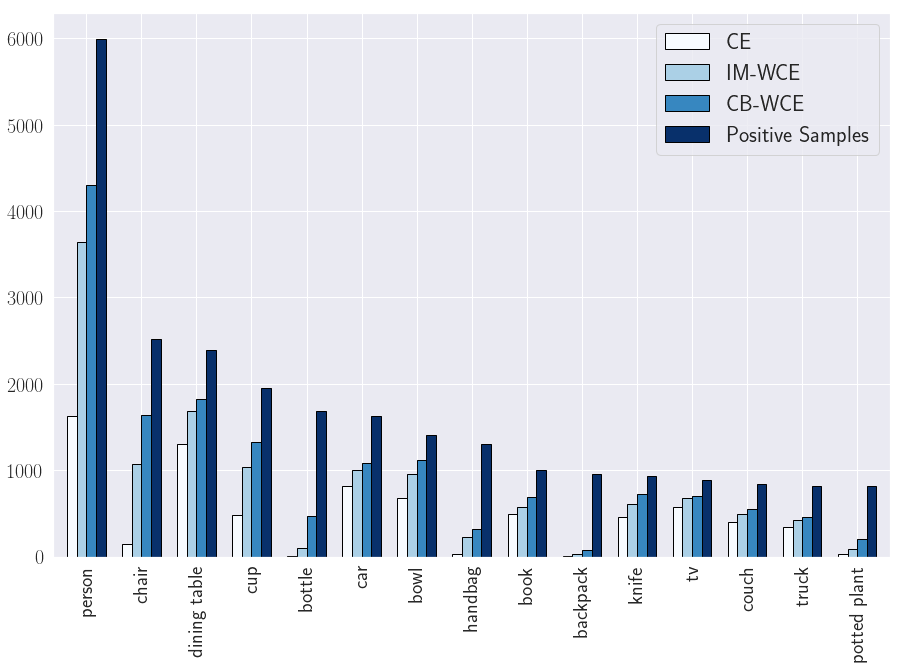

In [18]:
sn.set(font_scale=2)  # for label size
true_positives_df.iloc[:15,:].plot.bar(figsize=(15, 10), fontsize=20,width = 0.7,colormap="Blues",edgecolor = "black")
plt.savefig('/srv/workspace/research/mlml/figures/positive_samples.pdf',dpi=300, format = 'pdf', bbox_inches='tight')